# QSP Angle Learning
Can we learn the phase angles for a qsp sequence to approximate functions using gradient descent.

Goal: generate optimal QSP/QSVT sequences given constraints, where these constraints follow one of two schema whose character changes the nature of the search problem: (1) a party desires a specific quantum response function on a particular subspace, and (2) a party desires a specific discrimination behavior against a training set of known form.

Example problem: given a finite set of distinct $x_j \in [-1, 1]$, determine the minimal degree real polynomial of bounded norm which has roots $x_j$ and norm bounded by 1. If $W(x)$ has the form of $W(x_j)$ for some known set $x_j$, we can cancel the effect of $W(x_j)$.

We assume a noiseless setting.

In [2]:
from qsp_layers import *

# visualization tools
import seaborn as sns
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import IPython

sns.set()

In [3]:
InteractiveShell = IPython.core.interactiveshell.InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
def plot(history):
    plt.plot(history.history['loss'])
    plt.title("Learning QSP Angles")
    plt.xlabel("Iterations")
    plt.ylabel("Error")
    plt.show()


In [14]:
def make_qsp_model(poly_deg = 0):

    N = poly_deg
    q = cirq.GridQubit(0, 0)
    phis = [sympy.Symbol(f'phi{k}') for k in range(N + 1)]
    theta = [sympy.Symbol(f'th')]

    circuit = cirq.Circuit(cirq.rz(phis[0])(q))

    for k in range(1,N+1):
        c = cirq.Circuit(
            cirq.rx(theta[0])(q),
            cirq.rz(phis[k])(q)
        )
        circuit.append(c)
        
    controlled_qsp = HybridControlledPQC(circuit,operators = cirq.Z(q),
                          controlled_symbol_names=theta,
                          native_symbol_names=phis)
    
    theta_in = tf.keras.Input(shape=(1,),
                            # The circuit-tensor has dtype `tf.string` 
                            dtype=tf.float32,
                        name='theta')
    measurement = controlled_qsp(theta_in)

    return tf.keras.Model(inputs=theta_in, outputs=measurement), circuit

## Testing QSP angle estimation

This strategy for testing phases is designed for constructing polynomials with discrete properties. E.g. roots

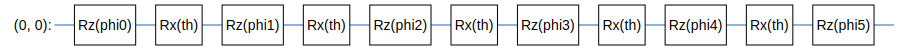

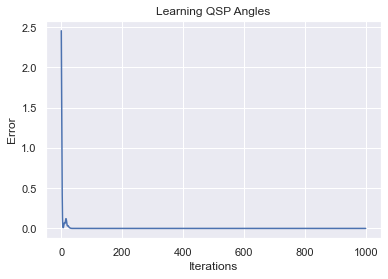

<AxesSubplot:xlabel='theta', ylabel='Z op'>

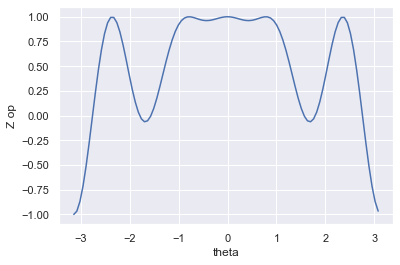

In [12]:
model, circuit = make_qsp_model(5)
SVGCircuit(circuit)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)

# The command input values to the classical NN.
th_in = np.array([[np.pi/4],[3*np.pi/4]], dtype=np.float32)
# The desired expectation value at output of quantum circuit.
expected_outputs = np.array([[1],[1]], dtype=np.float32)

history = model.fit(
    x=th_in,
    y=expected_outputs,
    epochs=1000,
    verbose=0)

plot(history)

all_th = np.arange(-np.pi,np.pi,np.pi/50)
out = tf.reshape(model.predict(all_th), (len(all_th,)))

sns.lineplot(x='theta',y='Z op',data={'theta': all_th,'Z op': out})


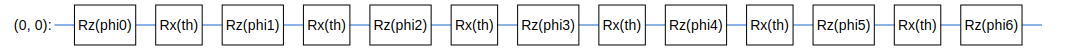

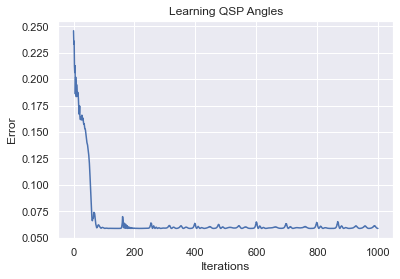

<AxesSubplot:xlabel='theta', ylabel='Z op'>

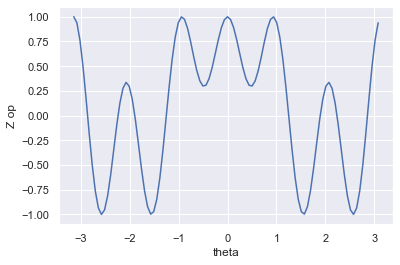

In [13]:
model, circuit = make_qsp_model(6)
SVGCircuit(circuit)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)

# The command input values to the classical NN.
th_in = np.array([[0],[0.5],[0.7],[1.9]], dtype=np.float32)
# The desired expectation value at output of quantum circuit.
expected_outputs = np.array([[1],[0],[1],[0]], dtype=np.float32)

history = model.fit(
    x=th_in,
    y=expected_outputs,
    epochs=1000,
    verbose=0)

plot(history)

all_th = np.arange(-np.pi,np.pi,np.pi/50)
out = tf.reshape(model.predict(all_th), (len(all_th,)))

sns.lineplot(x='theta',y='Z op',data={'theta': all_th,'Z op': out})


## Can we try using this method to approximate a continuous function?

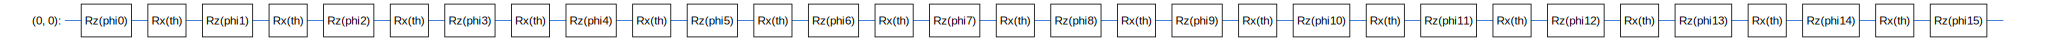

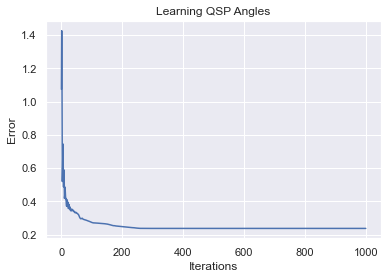

<AxesSubplot:xlabel='theta', ylabel='vals'>

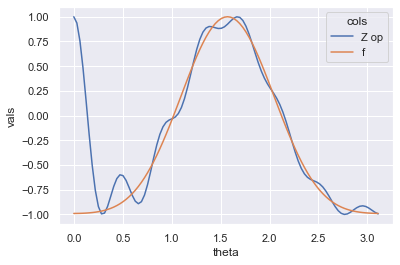

<AxesSubplot:xlabel='x', ylabel='vals'>

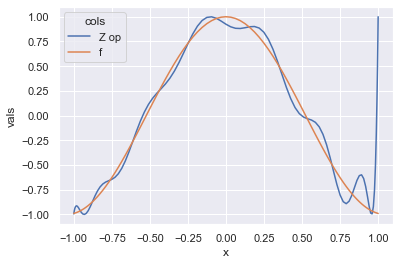

In [21]:
model, circuit = make_qsp_model(15)
SVGCircuit(circuit)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)


f = lambda x: np.cos(3*x)
# The command input values to the classical NN.
th_in = np.arange(0,np.pi,np.pi/20)
th_in = tf.reshape(th_in, (th_in.shape[0],1))

# The desired expectation value at output of quantum circuit.
expected_outputs = f(np.cos(th_in))

history = model.fit(
    x=th_in,
    y=expected_outputs,
    epochs=1000,
    verbose=0)

plot(history)

all_th = np.arange(0,np.pi,np.pi/100)
out = tf.reshape(model.predict(all_th), (len(all_th,)))
df = pd.DataFrame({'theta': all_th,'Z op': out, 'f': f(np.cos(all_th))})
df = df.melt('theta', var_name='cols',  value_name='vals')
sns.lineplot(x='theta', y="vals", hue='cols', data=df)
plt.show() 

df = pd.DataFrame({'x': np.cos(all_th),'Z op': out, 'f': f(np.cos(all_th))})
df = df.melt('x', var_name='cols',  value_name='vals')
sns.lineplot(x='x', y="vals", hue='cols', data=df)

## Moore-Penrose Pseudoinverse
An $\frac{\epsilon}{3}$-approximation of $\delta/2x$ on domain $[-1,1] \setminus (-\frac{\delta}{2},\frac{\delta}{2})$.

Require $0 <   \epsilon \leq \delta \leq \frac{1}{2}$.


See Gilyen 2018 Thm 41.


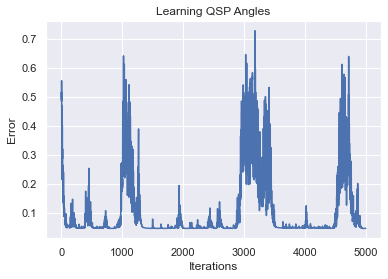

<AxesSubplot:xlabel='theta', ylabel='vals'>

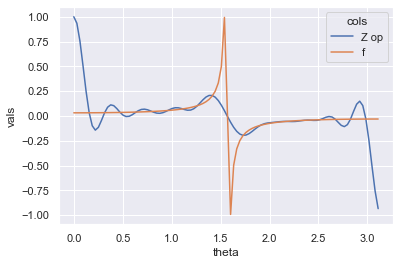

<AxesSubplot:xlabel='x', ylabel='vals'>

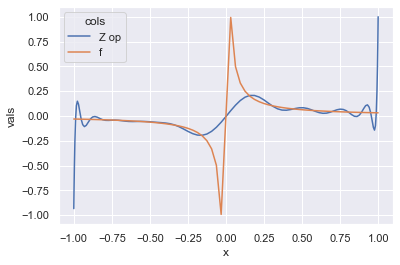

In [24]:
d = 1/16
e = 1/16
k = 2/d
poly_deg = int((np.log(1/e) / d))
b = np.ceil(k * k * np.log(k/e))
# let's just work with odd polys for now
poly_deg = poly_deg if (np.mod(poly_deg,2) == 1) else (poly_deg + 1)

# approximation to inverse function d/2x
f = lambda x: np.where(x!=0, d / 2 * (1 - (1 - x ** 2) ** b )/ x, 0)



model, circuit = make_qsp_model(poly_deg)
SVGCircuit(circuit)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)

    
# The command input values to the classical NN.
th_in = np.arange(0,np.pi,np.pi/20)
th_in = tf.reshape(th_in, (th_in.shape[0],1))

# The desired expectati/on value at output of quantum circuit.
expected_outputs = f(np.cos(th_in))

history = model.fit(
    x=th_in,
    y=expected_outputs,
    epochs=5000,
    verbose=0)

plot(history)

all_th = np.arange(0,np.pi,np.pi/100)
out = tf.reshape(model.predict(all_th), (len(all_th,)))
df = pd.DataFrame({'theta': all_th,'Z op': out, 'f': f(np.cos(all_th))})
df = df.melt('theta', var_name='cols',  value_name='vals')
sns.lineplot(x='theta', y="vals", hue='cols', data=df)
plt.show() 

df = pd.DataFrame({'x': np.cos(all_th),'Z op': out, 'f': f(np.cos(all_th))})
df = df.melt('x', var_name='cols',  value_name='vals')
sns.lineplot(x='x', y="vals", hue='cols', data=df)

In [28]:
model.trainable_weights

[<tf.Variable 'parameters:0' shape=(46,) dtype=float32, numpy=
 array([ 35.30405  , -13.7089405,   5.547995 ,  -5.903225 ,  35.734474 ,
          5.847201 , -12.129799 ,  -6.492646 ,   0.1178837, -10.716333 ,
        -35.9274   ,  11.57694  , -26.316994 ,  -2.834805 ,  -3.0239985,
         25.22024  ,  -5.2181087,  11.464012 , -23.094841 ,  15.651888 ,
         20.661606 , -10.718232 , -28.545065 ,  40.059998 , -16.238655 ,
         27.96737  ,  21.456211 ,  10.154708 ,   7.787817 ,  50.43048  ,
        -19.98443  , -10.943197 ,  -2.762984 ,  37.81553  , -17.501059 ,
         35.518032 ,  -4.5620866,   5.3760567,   7.553923 , -13.00285  ,
        -17.164352 , -16.960272 , -15.468642 ,  -0.9980511,   1.6774459,
         32.85567  ], dtype=float32)>]